<a href="https://colab.research.google.com/github/hemanthkumar17/Graph_Machine_Learning/blob/main/Graph_Clustering_CORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import networkx as nx
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import random

## Problem: Initialize r nodes as training set and apply label propagation to predict the labels of the unlabelled nodes

In [96]:
r = 4

### Label propagation with randomly initialized nodes

In [97]:
G = nx.karate_club_graph()
labels = {}

random.seed(2)

one_hot = {"Mr. Hi": -1, "Officer": 1}
node1 = []
node2 = []
for v in G.nodes():
    if G.nodes[v]["club"] == "Mr. Hi":
        node1.append(v)
    else:
        node2.append(v)

nodes = []
nodes += random.sample(node1, k=r//2)
nodes += random.sample(node2, k=r - r//2)
for node in nodes:
    labels[node] = one_hot[G.nodes[node]["club"]]

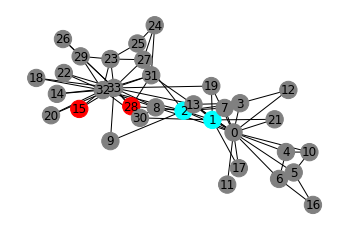

In [98]:
colors = []

for v in G.nodes():
    if v in labels:
        if labels[v] == 1:
            colors.append('red')
        else:
            colors.append('cyan')
    else:
        colors.append('gray')

pos = nx.spring_layout(G)
        
nx.draw_networkx_nodes(G, pos=pos, node_color=colors)
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.box(False)
plt.savefig('label-prop-input.png', dpi=150, bbox_inches='tight')

In [99]:
from sklearn.linear_model import LinearRegression

def laplacian_regularization(G, labels, k=2):
    L = nx.laplacian_matrix(G)
    eigvals, eigvecs = linalg.eigh(L.todense(), subset_by_index=(0,k-1))
    
    y = np.zeros(G.number_of_nodes())

    i = 0
    for v in G.nodes():
        if v in labels:
            y[i] = labels[v]
        i = i + 1
    
    reg = LinearRegression(fit_intercept=False).fit(eigvecs, y)
        
    y = reg.predict(eigvecs)
        
    y[y >= 0] = 1
    y[y < 0] = -1
        
    pred = {}
    
    i = 0
    for v in G.nodes():
        pred[v] = int(y[i])
        i = i + 1
        
    return pred

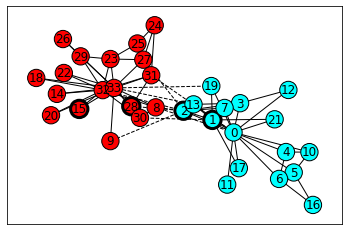

In [100]:
pred = laplacian_regularization(G, labels, k=2)

colors = []
widths = []

for v in G.nodes():
    if pred[v] == 1:
        colors.append('red')
    else:
        colors.append('cyan')
        
    if v in labels:
        widths.append(3.)
    else:
        widths.append(1.)

cut_edges = []
non_cut_edges = []

for e in G.edges():
    u,v = e
    if pred[u] != pred[v]:
        cut_edges.append(e)
    else:
        non_cut_edges.append(e)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, linewidths=widths)
nodes.set_edgecolor('black')
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, style='solid')

In [101]:
acc = 0
for v in G.nodes():
    if pred[v] == one_hot[G.nodes[v]["club"]]:
        acc += 1
acc /= len(G.nodes) / 100
print("Accuracy = " + str(acc) + "%")

Accuracy = 97.05882352941175%


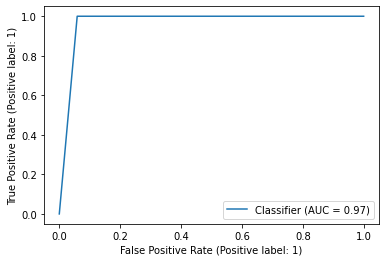

In [102]:
true = []
for v in G.nodes():
    if G.nodes[v]["club"] == 'Mr. Hi':
        true.append(one_hot["Mr. Hi"])
    else:
        true.append(one_hot["Officer"])
from sklearn import metrics
metrics.RocCurveDisplay.from_predictions(true, list(pred.values()))
fpr, tpr, thresholds = metrics.roc_curve(true, list(pred.values()))
auc1 = metrics.auc(fpr, tpr)

## Non-random initialization
### Cluster entire graph into r clusters



In [103]:
G = nx.karate_club_graph()


In [104]:
node1 = []
node2 = []
for v in G.nodes():
    if G.nodes[v]["club"] == "Mr. Hi":
        node1.append(v)
    else:
        node2.append(v)

In [105]:
G1 = G.subgraph(node1)
G2 = G.subgraph(node2)

In [106]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=r//2, affinity="nearest_neighbors",random_state=8, n_init=100)
pred1 = clust.fit_predict(nx.adjacency_matrix(G1))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [107]:
clust = SpectralClustering(n_clusters=r - r//2, affinity="nearest_neighbors",random_state=8, n_init=100)
pred2 = clust.fit_predict(nx.adjacency_matrix(G2))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [108]:
pred2

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int32)

In [109]:
deg = [[] for i in range(r//2)]
for p, v in zip(pred1, G1.nodes()):
    deg[p].append(v)
nodes = [max(d) for d in deg]

deg = [[] for i in range(r - r//2)]
for p, v in zip(pred2, G2.nodes()):
    deg[p].append(v)
nodes += [max(d) for d in deg]

In [110]:

labels = {}
one_hot = {"Mr. Hi": -1, "Officer": 1}
for node in nodes:
    labels[node] = one_hot[G.nodes[node]["club"]]

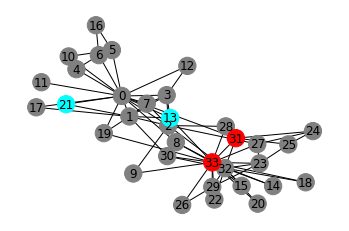

In [111]:
colors = []

for v in G.nodes():
    if v in labels:
        if labels[v] == 1:
            colors.append('red')
        else:
            colors.append('cyan')
    else:
        colors.append('gray')

pos = nx.spring_layout(G)
        
nx.draw_networkx_nodes(G, pos=pos, node_color=colors)
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.box(False)
plt.savefig('label-prop-input.png', dpi=150, bbox_inches='tight')

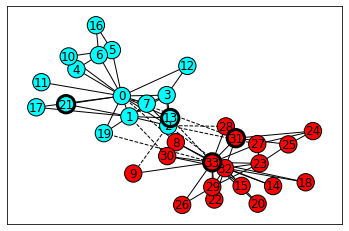

In [112]:
pred = laplacian_regularization(G, labels, k=2)

colors = []
widths = []

for v in G.nodes():
    if pred[v] == 1:
        colors.append('red')
    else:
        colors.append('cyan')
        
    if v in labels:
        widths.append(3.)
    else:
        widths.append(1.)

cut_edges = []
non_cut_edges = []

for e in G.edges():
    u,v = e
    if pred[u] != pred[v]:
        cut_edges.append(e)
    else:
        non_cut_edges.append(e)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, linewidths=widths)
nodes.set_edgecolor('black')
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, style='solid')

In [113]:
acc = 0
for v in G.nodes():
    if pred[v] == one_hot[G.nodes[v]["club"]]:
        acc += 1
acc /= len(G.nodes) / 100
print("Accuracy = " + str(acc) + "%")

Accuracy = 97.05882352941175%


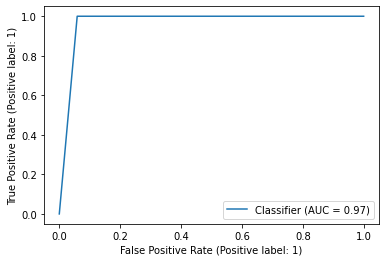

In [114]:
true = []
for v in G.nodes():
    if G.nodes[v]["club"] == 'Mr. Hi':
        true.append(one_hot["Mr. Hi"])
    else:
        true.append(one_hot["Officer"])
from sklearn import metrics
metrics.RocCurveDisplay.from_predictions(true, list(pred.values()))
fpr, tpr, thresholds = metrics.roc_curve(true, list(pred.values()))
auc1 = metrics.auc(fpr, tpr)

# Q4 CORA Clustering

In [115]:
# !pip install -q datasets

In [116]:
# from datasets import load_dataset

# dataset = load_dataset("gcaillaut/cora")

In [117]:
import networkx as nx

In [118]:
# G = nx.Graph()
# G.add_nodes_from(dataset['train']['node'])
# G.add_edges_from(dataset['train']['neighbors'])

In [119]:
!pip install -q torch_geometric torch_sparse torch_scatter

In [120]:
from torch_geometric.datasets import Planetoid
import networkx as nx
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')
data = dataset[0]
G = to_networkx(data, to_undirected=True)

In [121]:
import torch
lab = dataset[0].x
torch.where(lab==1)[1]

tensor([  19,   81,  146,  ..., 1328, 1412, 1414])

In [122]:
# !wget https://linqs-data.soe.ucsc.edu/public/datasets/cora/cora.zip
# !unzip cora.zip

In [123]:
# yG = nx.read_adjlist("cora/cora.cites", nodetype=int)

In [124]:
# G.nodes()

In [125]:
# dataset['train']['neighbors']

In [126]:
# dataset['train']['label']

In [127]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", random_state=1)
pred = clust.fit_predict(dataset[0].x)
print(pred)

KeyboardInterrupt: ignored

In [128]:
G = to_networkx(data, to_undirected=True)
a = nx.adjacency_matrix(G)

In [136]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", random_state=1)
pred = clust.fit_predict(a)
print(pred)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[0 0 1 ... 0 0 1]


In [137]:
np.where(pred>0)

(array([   2,   13,   24,   45,   48,   71,  143,  151,  157,  158,  160,
         165,  179,  201,  205,  215,  216,  226,  231,  232,  235,  261,
         297,  316,  318,  335,  343,  351,  366,  391,  416,  460,  467,
         476,  481,  511,  519,  521,  532,  547,  549,  563,  566,  568,
         576,  633,  637,  664,  673,  681,  699,  716,  729,  743,  745,
         766,  767,  784,  792,  795,  835,  845,  869,  874,  875,  899,
         962,  968, 1004, 1023, 1052, 1062, 1075, 1095, 1100, 1107, 1127,
        1166, 1212, 1241, 1272, 1297, 1299, 1301, 1323, 1331, 1334, 1337,
        1348, 1434, 1440, 1453, 1473, 1479, 1558, 1573, 1574, 1576, 1581,
        1636, 1665, 1697, 1701, 1704, 1799, 1808, 1809, 1811, 1812, 1813,
        1814, 1815, 1816, 1819, 1820, 1821, 1822, 1823, 1846, 1852, 1853,
        1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864,
        1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875,
        1876, 1877, 1944, 1946, 1947, 